Confusion matrix (rows: true, cols: pred):
[[99052   948]
 [76794 23206]]

Classification report (labels +1 normal, -1 anomaly):
              precision    recall  f1-score   support

           1       0.56      0.99      0.72    100000
          -1       0.96      0.23      0.37    100000

    accuracy                           0.61    200000
   macro avg       0.76      0.61      0.55    200000
weighted avg       0.76      0.61      0.55    200000


ROC AUC (anomaly as positive): 0.8498


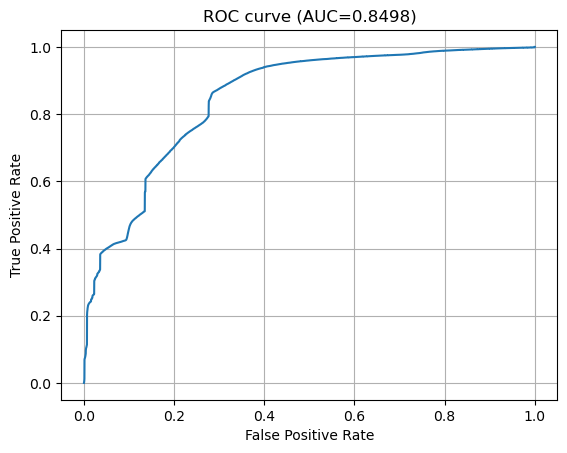

['ocsvm_iot_model.pkl']

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt
import joblib

# Giả sử bạn có 2 file:
# - normal.csv: toàn mẫu bình thường (đã scale), dùng để train
# - test_mixed.csv: chứa cả normal và anomaly, có cột 'label' với {1: normal, -1: anomaly}

X_train = pd.read_csv("unsupervised_dataset.csv").values.astype(np.float32)   # chỉ normal
df_test = pd.read_csv("evaluation_dataset.csv")
X_test = df_test.drop(columns=["label"]).values.astype(np.float32)
y_test = df_test["label"].values.astype(int)  # +1 normal, -1 anomaly

# Huấn luyện One-Class SVM
ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.01)  # điều chỉnh nu theo suy đoán tỉ lệ anomaly
ocsvm.fit(X_train)

# Dự đoán nhãn (sklearn trả +1/-1)
y_pred = ocsvm.predict(X_test)

# Báo cáo (dạng +1/-1)
print("Confusion matrix (rows: true, cols: pred):")
print(confusion_matrix(y_test, y_pred, labels=[1,-1]))

print("\nClassification report (labels +1 normal, -1 anomaly):")
print(classification_report(y_test, y_pred, labels=[1,-1]))

# Dùng decision_function để tính ROC/AUC:
# decision_function: lớn hơn -> càng "normal". Để tính ROC cho anomaly (positive=anomaly), đảo dấu.
scores = -ocsvm.decision_function(X_test)  # đảo: score lớn -> nhiều khả năng là anomaly
# map y_test to binary: anomaly=1, normal=0
y_binary = (y_test == -1).astype(int)

auc = roc_auc_score(y_binary, scores)
print(f"\nROC AUC (anomaly as positive): {auc:.4f}")

# Vẽ ROC curve (tùy chọn)
fpr, tpr, thr = roc_curve(y_binary, scores)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={auc:.4f})")
plt.grid(True)
plt.show()

# Lưu model
joblib.dump(ocsvm, "ocsvm_iot_model.pkl")
